In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report, confusion_matrix

In [3]:
TRAIN_DIR = "/Users/Mareikes/Desktop/Wahlpflicht_AI/projekt_emotions/emotion_dataset/datasets/train"


In [4]:
from pathlib import Path
# Zielpfad definieren (relativ zum Skript)
OUT_DIR = Path("../output")
OUT_DIR.mkdir(parents=True, exist_ok=True)  # Ordner erstellen, falls er noch nicht existiert

### Training

In [ ]:
batch_size = 16 
img_height = 256
img_width = 256

In [5]:
# Erstellen des Trainingsdatensatzes aus dem lokalen Verzeichnis
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  validation_split=0.1,  # 10 % der Trainingsdaten für Validierung
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels='inferred', #von chatgpt
  label_mode='int',   
  shuffle=True
)

Found 2000 files belonging to 5 classes.
Using 1800 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  validation_split=0.1,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels='inferred', #von chatgpt
  label_mode='int',    
  shuffle=True
  )

Found 2000 files belonging to 5 classes.
Using 200 files for validation.


In [7]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Angry' 'Happy' 'Neutral' 'Sad' 'Surprise']


In [8]:
#konfigurieren
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
#Augmentation ausgewählt weniger für Gesichter
data_augmentation = tf.keras.Sequential([
    keras.Input(shape=(img_height, img_width, 3)),
    
    layers.RandomFlip("horizontal"), # horizontales Spiegeln ist bei Gesichtern okay
    layers.RandomRotation(0.1), # ±10% Drehung ist ausreichend
    layers.RandomZoom(0.1), # ±10% Zoom verändert nicht zu stark
    ])


2025-05-24 14:35:24.231512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


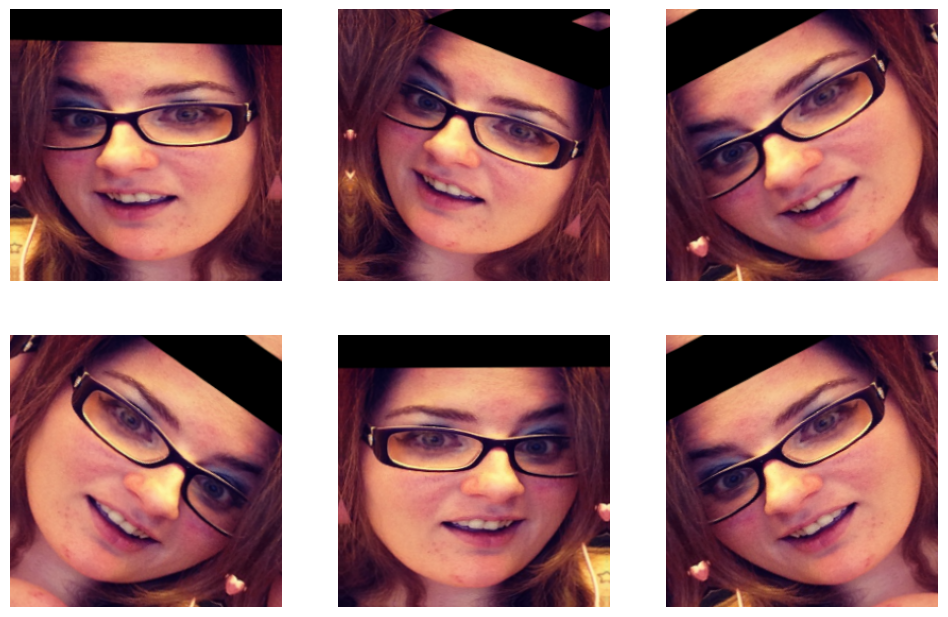

In [10]:
#Beispielhaft Augmentation ansehen
plt.figure(figsize=(12, 12))
for images, _ in train_ds.take(1):
  for i in range(6):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [11]:
num_classes = len(class_names)

In [12]:
#Modell aufbauen
model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes) #sollte softmax sein lt Buch
])


In [13]:
#Callbacks mit verschiedenen Funktionen
#Training vorzeitig stoppen
early_stopping = EarlyStopping(
    monitor='val_loss',    # Überwacht die Validierungs-Fehler
    patience=5,           # Stoppt Training, wenn sich 5 Epochen lang nichts verbessert
    restore_best_weights=True  # Lädt die besten Gewichte automatisch
)

#Lernrate überwachen und anpassen
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Überwacht die Validierungs-Fehler
    factor=0.5,            # Halbiert die Lernrate
    patience=5,            # Nach 5 Epochen ohne Verbesserung
    min_lr=1e-6            # Untere Grenze der Lernrate
)

#bestes Modell speichern
out_path = OUT_DIR / f'cnn_v1_16.keras'
checkpoint = ModelCheckpoint(
    out_path,             # Dateiname für das gespeicherte Modell
    monitor='val_loss',           # überwacht den Validation Loss
    save_best_only=True,          # nur speichern, wenn sich das Modell verbessert
    mode='min',                   # niedrigere val_loss ist besser
    save_weights_only=False       # speichert das ganze Modell, nicht nur Gewichte
)

In [14]:
#kompilieren, optimizer, loss und metrik
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
#modell übersicht
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,965 (32.09 MB)

 Trainable params: 8,412,965 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#training mit callbacks starten
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 237ms/step - accuracy: 0.1999 - loss: 1.9819 - val_accuracy: 0.2400 - val_loss: 1.6099 - learning_rate: 0.0010
Epoch 2/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 285ms/step - accuracy: 0.2790 - loss: 1.5805 - val_accuracy: 0.3050 - val_loss: 1.5516 - learning_rate: 0.0010
Epoch 3/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 295ms/step - accuracy: 0.3009 - loss: 1.5305 - val_accuracy: 0.3300 - val_loss: 1.4586 - learning_rate: 0.0010
Epoch 4/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 274ms/step - accuracy: 0.3635 - loss: 1.4382 - val_accuracy: 0.3550 - val_loss: 1.5034 - learning_rate: 0.0010
Epoch 5/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 273ms/step - accuracy: 0.3905 - loss: 1.4067 - val_accuracy: 0.4150 - val_loss: 1.4318 - learning_rate: 0.0010
Epoch 6/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 255ms/step - accuracy: 0.4369 - loss: 1.3678 - val_accuracy: 0.4100 - val_loss: 1.3518 - learning_rate: 0.0010
Epoch 7/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 272ms/step - accuracy: 0.4

### Trainingsverlauf visualisieren

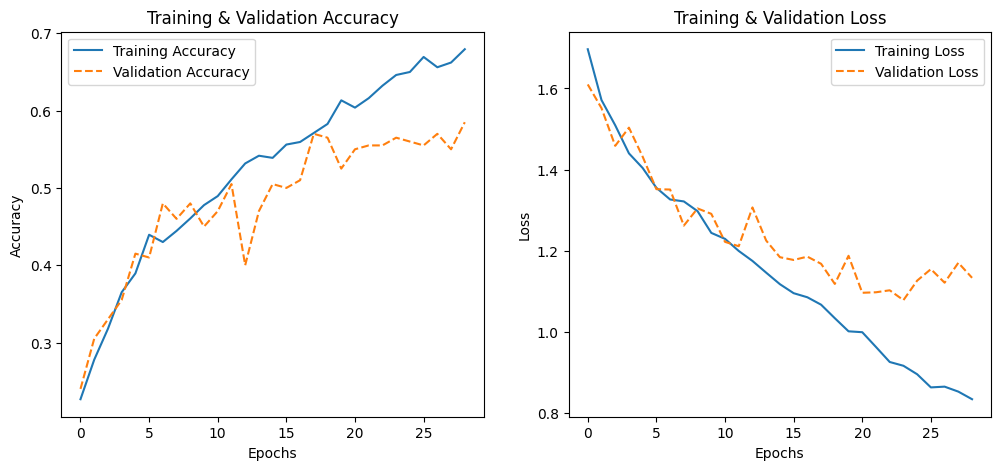

In [17]:
# Trainingsergebnisse aus dem `history`-Objekt extrahieren
history_dict = history.history

# Accuracy (Genauigkeit)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Loss (Fehlerrate)
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()


plt.show()

### Evaluierung

In [18]:
TEST_DIR = "/Users/Mareikes/Desktop/Wahlpflicht_AI/projekt_emotions/emotion_dataset/datasets/test"

In [19]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  TEST_DIR,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels='inferred', #von chatgpt
  label_mode='int',    
  shuffle=True
  ) 

Found 500 files belonging to 5 classes.


In [20]:
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━

2025-05-24 14:51:00.453675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


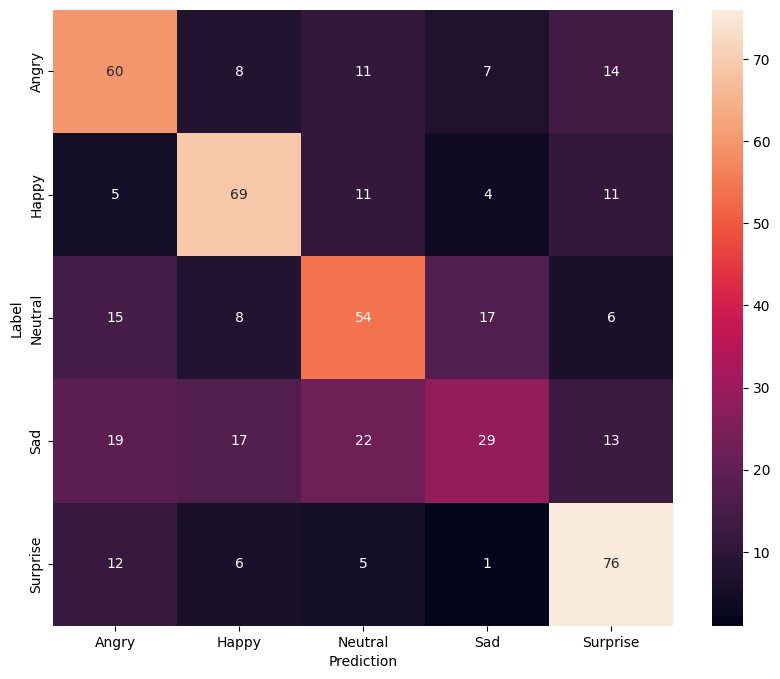

              precision    recall  f1-score   support

       Angry       0.54      0.60      0.57       100
       Happy       0.64      0.69      0.66       100
     Neutral       0.52      0.54      0.53       100
         Sad       0.50      0.29      0.37       100
    Surprise       0.63      0.76      0.69       100

    accuracy                           0.58       500
   macro avg       0.57      0.58      0.56       500
weighted avg       0.57      0.58      0.56       500



In [21]:
# Vorhersagen & Labels sammeln
all_labels = []
all_preds = []

for images, labels in test_ds:
    preds = model.predict(images)
    pred_classes = tf.argmax(preds, axis=-1)
    all_labels.extend(labels.numpy())
    all_preds.extend(pred_classes.numpy())

# Confusion Matrix & Klassifikationsbericht
cm = confusion_matrix(all_labels, all_preds)
show_confusion_matrix(cm, class_names)
print(classification_report(all_labels, all_preds, target_names=class_names))

### Vorhersagen

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


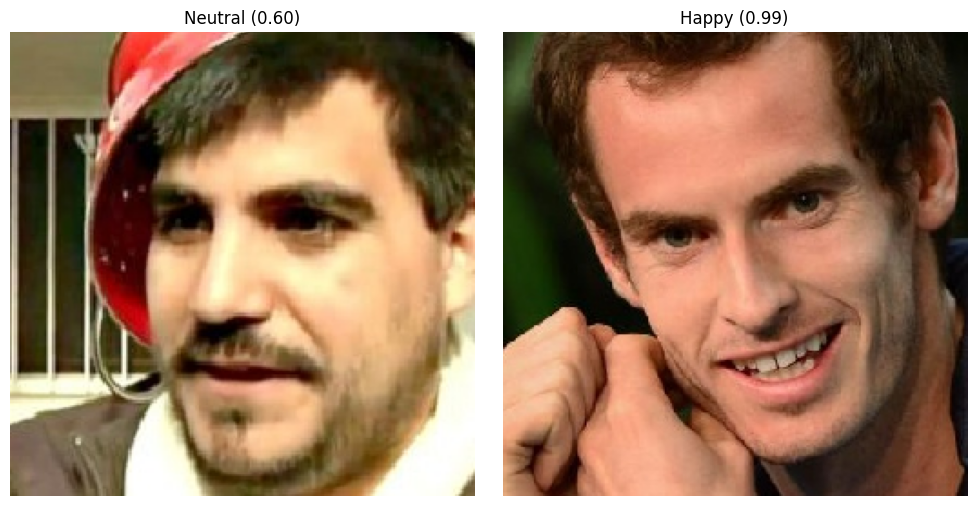

In [26]:
# Klassen definieren (anpassen)
class_names = np.array(['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise'])


# Bildgröße
img_height, img_width = 256, 256

# Zwei zufällige Bilder auswählen
image_paths = []
for root, _, files in os.walk(TEST_DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

image_paths = np.random.choice(image_paths, 2, replace=False)

# Visualisierung mit Vorhersage
plt.figure(figsize=(10, 5))
for i, path in enumerate(image_paths):
    img = image.load_img(path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    #img_batch = np.expand_dims(img_array / 255.0, axis=0)

    # WICHTIG: Kein weiteres preprocess_input mehr nötig – Lambda-Schicht ist im Modell enthalten
    #predictions = model.predict(img_batch)
    #probabilities = predictions[0]
    logits = model.predict(img_batch)
    probabilities = tf.nn.softmax(logits[0]).numpy() 

    predicted_class = np.argmax(probabilities)
    confidence = probabilities[predicted_class]

    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{class_names[predicted_class]} ({confidence:.2f})")
plt.tight_layout()
plt.show()
